<a href="https://colab.research.google.com/github/pattom72/dw_matrix_car/blob/master/day3_simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install --upgrade tables
#!pip install eli5

In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5 
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two


In [0]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [0]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy Model

In [0]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [0]:
feats = ['car_id']
x = df[ feats ].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(x, y)
y_pred = model.predict(x)

mae(y, y_pred)

39465.934630440985

In [0]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [0]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [0]:
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 155)

## Features

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
   if isinstance(df[feat][0], list): continue

   factorized_values = df[feat].factorize()[0]
   if SUFFIX_CAT in feat:
     df[feat] = factorized_values
   else:
     df[feat + SUFFIX_CAT] = factorized_values
     
   
   df[feat + SUFFIX_CAT] = df[feat].factorize()[0]

In [0]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x ]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [0]:
x = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, x, y, cv=3, scoring = 'neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [0]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(x, y)

imp = PermutationImportance(m, random_state=0).fit(x, y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_func=[np.mean, np.median, np.size], feat_sort='size', top=50, subplots=True):

  (df
      .groupby(feat_groupby)[feat_agg]
      .agg(agg_func)
      .sort_values(by=feat_sort, ascending=False)
      .head(top)
  ).plot(kind='bar', figsize=(15,10), subplots=subplots)

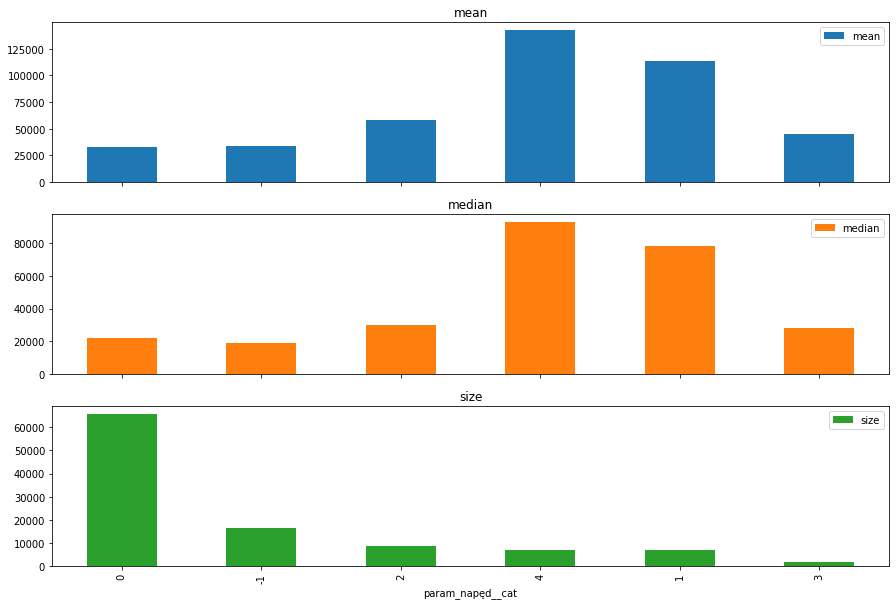

In [0]:
group_and_barplot('param_napęd__cat');